<a href="https://colab.research.google.com/github/Robertgaraban/Calculo-de-Estructuras-Navales-FNB/blob/main/Figuras_con_mas_de_fuerza.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

=== Desplazamientos (mm) ===
Nodo 2: U = 0.01, V = -0.00
Nodo 3: U = 0.01, V = -0.00

=== Reacciones (kN) ===
Nodo 1: Rx = -30.00, Ry = -9.00
Nodo 4: Rx = 0.00, Ry = 34.00

=== Fuerzas en barras (kN) ===
Barra 1: -15.00 kN (Compresión)
Barra 2: -0.00 kN (Compresión)
Barra 3: -34.00 kN (Compresión)
Barra 4: 38.42 kN (Tracción)


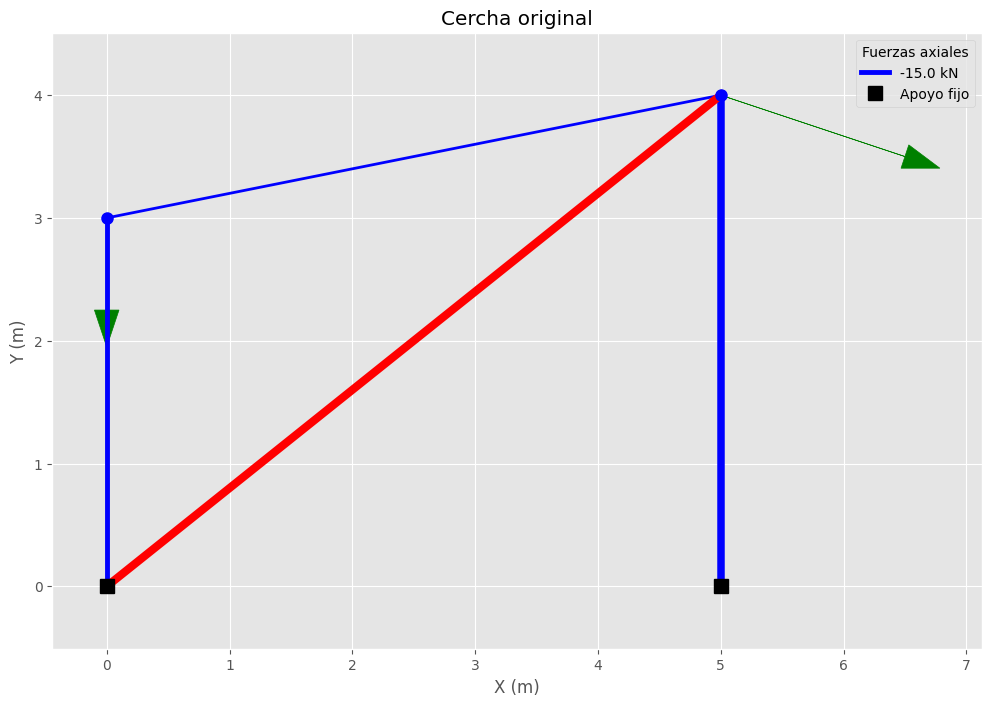

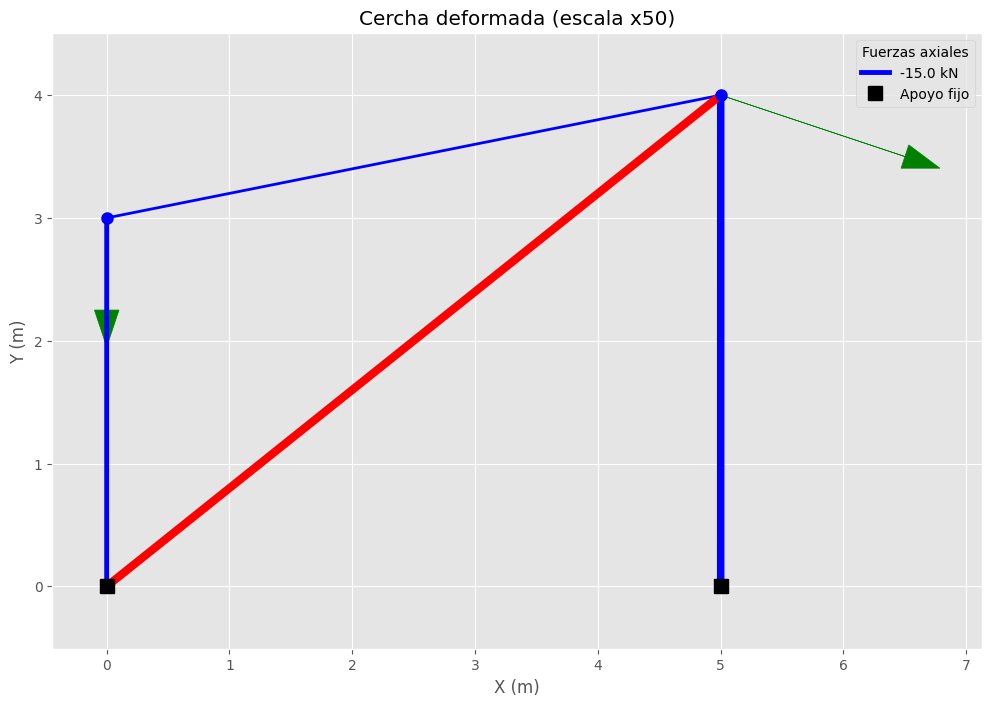

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML

# Configuración inicial
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = [12, 8]

class Cercha2D:
    def __init__(self):
        # Propiedades del material (acero)
        self.E = 205000  # MPa (Módulo de Young)
        self.factor_escala = 50  # Factor para visualizar deformaciones

        # Definición de nodos [x, y] en metros
        self.nodos = np.array([
            [0, 0],   # Nodo 1
            [0, 3],   # Nodo 2
            [5, 4],   # Nodo 3
            [5, 0]    # Nodo 4
        ])

        # Definición de barras [nodo_i, nodo_j, tipo, dimension, espesor]
        # tipo: 0 = cuadrada, 1 = circular
        self.barras = [
            [0, 1, 0, 100, 1],  # Barra 1 (cuadrada)
            [1, 2, 0, 100, 1],  # Barra 2 (cuadrada)
            [3, 2, 0, 100, 1],  # Barra 3 (cuadrada)
            [0, 2, 1, 100, 1]   # Barra 4 (circular)
        ]

        # Fuerzas aplicadas [Fx, Fy] en kN
        self.fuerzas = np.array([
            [0, 0],    # Nodo 1 (reacciones)
            [0, -15],  # Nodo 2
            [30, -10], # Nodo 3
            [0, 0]     # Nodo 4 (reacciones)
        ])

        # Grados de libertad restringidos (1 = restringido)
        self.restr = np.array([
            [1, 1],  # Nodo 1
            [0, 0],  # Nodo 2
            [0, 0],  # Nodo 3
            [1, 1]   # Nodo 4
        ])

        # Inicializar resultados
        self.desplazamientos = None
        self.reacciones = None
        self.fuerzas_barras = None

    def calcular_areas(self):
        """Calcula áreas de las secciones transversales en cm²"""
        areas = []
        for barra in self.barras:
            tipo, dim, esp = barra[2], barra[3], barra[4]
            if tipo == 0:  # Cuadrada
                area = (dim**2 - (dim-2*esp)**2) / 100  # cm²
            else:  # Circular
                area = (np.pi*(dim/2)**2 - np.pi*(dim/2-esp)**2) / 100  # cm²
            areas.append(area)
        return np.array(areas)

    def calcular_longitudes(self):
        """Calcula longitudes de las barras en metros / estoy no estoy seguro se
        deberiamos dejarlo todo en cm y asi tendremos calculos mas visales"""
        longitudes = []
        for barra in self.barras:
            ni, nj = barra[0], barra[1]
            xi, yi = self.nodos[ni]
            xj, yj = self.nodos[nj]
            longitud = np.sqrt((xj-xi)**2 + (yj-yi)**2)
            longitudes.append(longitud)
        return np.array(longitudes)

    def calcular_angulos(self):
        """Calcula ángulos de las barras en radianes"""
        angulos = []
        for barra in self.barras:
            ni, nj = barra[0], barra[1]
            xi, yi = self.nodos[ni]
            xj, yj = self.nodos[nj]
            angulo = np.arctan2(yj-yi, xj-xi)
            angulos.append(angulo)
        return np.array(angulos)

    def ensamblar_matriz_rigidez(self):
        """Ensambla la matriz de rigidez global"""
        n_nodos = len(self.nodos)
        K_global = np.zeros((2*n_nodos, 2*n_nodos))
        areas = self.calcular_areas()
        longitudes = self.calcular_longitudes()
        angulos = self.calcular_angulos()

        for idx, barra in enumerate(self.barras):
            ni, nj = barra[0], barra[1]
            A = areas[idx]
            L = longitudes[idx]
            theta = angulos[idx]

            # Matriz de rigidez local
            k = (self.E * 100 * A) / L  # kN/m (convertimos E a kN/cm²)
            c = np.cos(theta)
            s = np.sin(theta)

            # Matriz de transformación
            T = np.array([
                [c, s, 0, 0],
                [0, 0, c, s]
            ])

            # Matriz de rigidez en coordenadas globales
            K_elem = k * np.array([
                [c**2, c*s, -c**2, -c*s],
                [c*s, s**2, -c*s, -s**2],
                [-c**2, -c*s, c**2, c*s],
                [-c*s, -s**2, c*s, s**2]
            ])

            # Posiciones en la matriz global
            gdl_i = 2*ni
            gdl_j = 2*nj

            # Ensamblar en matriz global
            K_global[gdl_i:gdl_i+2, gdl_i:gdl_i+2] += K_elem[:2, :2]
            K_global[gdl_i:gdl_i+2, gdl_j:gdl_j+2] += K_elem[:2, 2:]
            K_global[gdl_j:gdl_j+2, gdl_i:gdl_i+2] += K_elem[2:, :2]
            K_global[gdl_j:gdl_j+2, gdl_j:gdl_j+2] += K_elem[2:, 2:]

        return K_global

    def resolver_sistema(self):
        """Resuelve el sistema de ecuaciones para obtener desplazamientos"""
        K = self.ensamblar_matriz_rigidez()
        n_nodos = len(self.nodos)

        # Vector de fuerzas
        F = self.fuerzas.flatten()

        # Identificar grados de libertad libres y restringidos
        restr_flat = self.restr.flatten()
        libres = np.where(restr_flat == 0)[0]
        fijos = np.where(restr_flat == 1)[0]

        # Particionar matriz y vector
        K_ll = K[np.ix_(libres, libres)]
        K_lf = K[np.ix_(libres, fijos)]
        F_l = F[libres]

        # Resolver sistema
        U_l = np.linalg.solve(K_ll, F_l)

        # Ensamblar vector de desplazamientos completo
        U = np.zeros(2*n_nodos)
        U[libres] = U_l
        U[fijos] = 0  # Desplazamientos en apoyos

        # Calcular reacciones
        R = K @ U - F

        # Guardar resultados
        self.desplazamientos = U.reshape(n_nodos, 2)
        self.reacciones = R.reshape(n_nodos, 2)

        # Calcular fuerzas en barras
        self.calcular_fuerzas_barras()

    def calcular_fuerzas_barras(self):
        """Calcula fuerzas axiales en las barras"""
        areas = self.calcular_areas()
        longitudes = self.calcular_longitudes()
        angulos = self.calcular_angulos()
        fuerzas = []

        for idx, barra in enumerate(self.barras):
            ni, nj = barra[0], barra[1]
            A = areas[idx]
            L = longitudes[idx]
            theta = angulos[idx]

            # Desplazamientos de los nodos
            ui, vi = self.desplazamientos[ni]
            uj, vj = self.desplazamientos[nj]

            # Deformación axial
            delta_L = (uj-ui)*np.cos(theta) + (vj-vi)*np.sin(theta)

            # Fuerza axial (kN)
            fuerza = (self.E * 100 * A) * delta_L / L
            fuerzas.append(fuerza)

        self.fuerzas_barras = np.array(fuerzas)

    def visualizar_cercha(self, deformada=False):
        """Visualiza la cercha con o sin deformación"""
        fig, ax = plt.subplots()

        # Coordenadas originales o deformadas
        if deformada:
            nodos = self.nodos + self.desplazamientos * self.factor_escala
            titulo = "Cercha deformada (escala x{})".format(self.factor_escala)
        else:
            nodos = self.nodos
            titulo = "Cercha original"

        # Dibujar barras
        for idx, barra in enumerate(self.barras):
            ni, nj = barra[0], barra[1]
            xi, yi = nodos[ni]
            xj, yj = nodos[nj]

            # Color según fuerza (rojo = tracción, azul = compresión)
            if hasattr(self, 'fuerzas_barras'):
                fuerza = self.fuerzas_barras[idx]
                color = 'red' if fuerza > 0 else 'blue'
                ancho = 2 + abs(fuerza) / 10
                etiqueta = "{:.1f} kN".format(fuerza)
            else:
                color = 'gray'
                ancho = 1
                etiqueta = None

            ax.plot([xi, xj], [yi, yj], color=color, linewidth=ancho,
                    label=etiqueta if idx == 0 else None)

        # Dibujar nodos
        for i, (x, y) in enumerate(nodos):
            if self.restr[i, 0] == 1 and self.restr[i, 1] == 1:
                ax.plot(x, y, 'ks', markersize=10, label='Apoyo fijo' if i == 0 else None)
            elif self.restr[i, 0] == 1 or self.restr[i, 1] == 1:
                ax.plot(x, y, 'ko', markersize=10, label='Apoyo móvil' if i == 0 else None)
            else:
                ax.plot(x, y, 'bo', markersize=8, label='Nodo libre' if i == 0 else None)

        # Dibujar fuerzas
        for i, (fx, fy) in enumerate(self.fuerzas):
            if fx != 0 or fy != 0:
                ax.arrow(nodos[i, 0], nodos[i, 1],
                         fx/20, fy/20, head_width=0.2,
                         head_length=0.3, fc='green', ec='green',
                         label='Fuerza aplicada' if i == 0 else None)

        ax.set_title(titulo)
        ax.set_xlabel('X (m)')
        ax.set_ylabel('Y (m)')
        ax.grid(True)
        ax.axis('equal')

        if hasattr(self, 'fuerzas_barras'):
            ax.legend(title="Fuerzas axiales")

        plt.show()

    def animar_deformacion(self):
        """Crea una animación de la deformación"""
        fig, ax = plt.subplots()

        # Inicializar elementos gráficos
        lineas = []
        for barra in self.barras:
            ni, nj = barra[0], barra[1]
            linea, = ax.plot([], [], 'b-', lw=2)
            lineas.append(linea)

        puntos = []
        for i in range(len(self.nodos)):
            punto, = ax.plot([], [], 'ro', markersize=8)
            puntos.append(punto)

        # Configurar ejes
        ax.set_xlim(-1, 6)
        ax.set_ylim(-1, 5)
        ax.set_title('Animación de deformación')
        ax.grid(True)

        def init():
            for linea in lineas:
                linea.set_data([], [])
            for punto in puntos:
                punto.set_data([], [])
            return lineas + puntos

        def animate(t):
            factor = t/100 * self.factor_escala
            nodos_deformados = self.nodos + self.desplazamientos * factor

            for idx, barra in enumerate(self.barras):
                ni, nj = barra[0], barra[1]
                xi, yi = nodos_deformados[ni]
                xj, yj = nodos_deformados[nj]
                lineas[idx].set_data([xi, xj], [yi, yj])

            for i, (x, y) in enumerate(nodos_deformados):
                puntos[i].set_data(x, y)

            return lineas + puntos

        anim = FuncAnimation(fig, animate, frames=100, init_func=init,
                             blit=True, interval=50)

        plt.close()
        return HTML(anim.to_jshtml())

# Crear y analizar la cercha
cercha = Cercha2D()
cercha.resolver_sistema()

# Mostrar resultados
print("=== Desplazamientos (mm) ===")
print("Nodo 2: U = {:.2f}, V = {:.2f}".format(*cercha.desplazamientos[1]*1000))
print("Nodo 3: U = {:.2f}, V = {:.2f}".format(*cercha.desplazamientos[2]*1000))

print("\n=== Reacciones (kN) ===")
print("Nodo 1: Rx = {:.2f}, Ry = {:.2f}".format(*cercha.reacciones[0]))
print("Nodo 4: Rx = {:.2f}, Ry = {:.2f}".format(*cercha.reacciones[3]))

print("\n=== Fuerzas en barras (kN) ===")
for i, fuerza in enumerate(cercha.fuerzas_barras, 1):
    print(f"Barra {i}: {fuerza:.2f} kN ({'Tracción' if fuerza > 0 else 'Compresión'})")

# Visualización
cercha.visualizar_cercha(deformada=False)
cercha.visualizar_cercha(deformada=True)

# Animación (solo en Jupyter/Colab)
# display(cercha.animar_deformacion())